# Einfluss des Regionstyps (Urban vs. Rural) auf die Verspätung

### 1. Forschungsfrage & Motivation
Ziel dieser Analyse ist es, empirisch zu prüfen, ob die Urbanität einer Region (städtisch vs. ländlich) einen signifikanten Einfluss auf das Verspätungsaufkommen im Schweizer Schienennetz hat.

**Wissenschaftliche Intuition:**
* **Urbane Gebiete:** Gekennzeichnet durch hohe Netzdichte und komplexe Knotenpunkte. Hier besteht die Hypothese einer höheren Anfälligkeit für Domino-Effekte.
* **Ländliche Gebiete:** Geringere Taktung, aber oft eingleisige Streckenabschnitte, die bei Störungen zu massiven Engpässen führen können.

**Statistische Hypothesen:**
* **Nullhypothese ($H_0$):** Es gibt keinen Unterschied in der zentralen Tendenz der Verspätungen zwischen urbanen und ruralen Gebieten ($Median_{Urban} = Median_{Rural}$).
* **Alternativhypothese ($H_1$):** Es existiert ein statistisch signifikanter Unterschied in der Verspätungsverteilung.

**Methodisches Vorgehen:**
1. **Data Enrichment:** Fusion der SBB-Ist-Daten mit der BFS-Gemeindetypologie 2020 via **Fuzzy String Matching**, um Haltestellen (BPUIC) eindeutig Regionstypen zuzuweisen.
2. **Inferenzstatistik:** Anwendung des nicht-parametrischen **Kruskal-Wallis-H-Tests** (aufgrund der vorliegenden Rechtsschiefe und fehlender Normalverteilung).
3. **Relevanzprüfung:** Berechnung der **Effektstärke $\epsilon^2$** (Epsilon-Squared), um zwischen rein statistischer Signifikanz (begünstigt durch $N > 4$ Mio.) und praktischer Relevanz zu unterscheiden.

In [45]:
# Standardbibliotheken für Datenverarbeitung und numerische Operationen
import polars as pl
import pandas as pd
import numpy as np
from pathlib import Path

# Geodaten-Verarbeitung und topologische Operationen
import geopandas as gpd
from shapely.ops import transform

# Statistische Tests und algorithmisches Matching
from scipy.stats import kruskal  # Nicht-parametrischer H-Test für Lageunterschiede
from difflib import get_close_matches  # Algorithmus für das Fuzzy-Matching der Gemeindenamen

# Visualisierung: Statisch (Seaborn/Matplotlib) und Interaktiv (Folium)
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from branca.colormap import StepColormap


# Konfiguration der Visualisierung
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['axes.titlesize'] = 16

print("Setup abgeschlossen. Polars Version:", pl.__version__)

Setup abgeschlossen. Polars Version: 1.36.1


## 2. Datenintegration & Preprocessing

Um die Verspätungsdaten räumlich zu kontextualisieren, führen wir eine Datenfusion aus drei primären Quellen durch:

1.  **SBB-Ist-Daten (`istdata_clean.parquet`):** Unser bereinigter Kern-Datensatz, der die Ankunfts- und Abfahrtsverspätungen auf Bahnhofsebene enthält.
2.  **Dienststellen-Stammdaten (`dienststellen.csv`):** Diese fungieren als Brückentabelle, um die technische Bahnhofs-ID (`BPUIC`) einem physischen Ort bzw. einer Gemeinde zuzuordnen.
3.  **BFS-Gemeindetypologie (`Boundaries_...gpkg`):** Enthält die offiziellen Geometrien und die statistische Klassifizierung (Variable `STALAN2020`) der Siedlungsstruktur des Bundesamts für Statistik.

**Vorgehen:** Wir nutzen **Polars** für die performante Verarbeitung der Millionen von Zugdatensätzen und **GeoPandas** für die räumlichen Relationen. Die Gemeindenamen werden bereinigt (z.B. Entfernen von Stadtkreis-Zusätzen), um die Trefferrate beim anschliessenden Matching zu maximieren.

In [46]:
# Pfaddefinitionen
DATA_PATH = Path("../data")
PROCESSED_PATH = DATA_PATH / "processed"
EXTERNAL_PATH = DATA_PATH / "external"

# 1. Laden der Verspätungsdaten (Lazy Loading für speicherschonende Verarbeitung)
# Wir stellen sicher, dass die Bahnhofs-ID (BPUIC) als String vorliegt
df_raw = pl.scan_parquet(PROCESSED_PATH / "istdata_trains_clean.parquet").with_columns(
    pl.col("BPUIC").cast(pl.Utf8).str.strip_chars()
)

# 2. Einlesen der Bahnhofs-Stammdaten (Mapping BPUIC -> Gemeinde)
# Wir nutzen Pandas aufgrund der flexibleren automatischen Trenner-Erkennung bei CSVs
dienst_raw = pd.read_csv(
    EXTERNAL_PATH / "dienststellen.csv",
    sep=None, engine="python", encoding="utf-8"
)

# Datenbereinigung: Nur Schweizer Bahnhöfe, Validierung der Namen
dienst_ch = dienst_raw[
    (dienst_raw["isoCountryCode"] == "CH") & 
    (dienst_raw["number"].notna()) & 
    (dienst_raw["municipalityName"].notna())
].copy()

# Normalisierung: "Zürich (Kreis 1)" -> "Zürich" für besseres Joining
dienst_ch["municipalityName"] = dienst_ch["municipalityName"].str.replace(r"\s*\(.*\)", "", regex=True)

# Konvertierung in Polars-Frame für die weitere Pipeline
df_stations = pl.from_pandas(dienst_ch[["number", "municipalityName", "cantonAbbreviation"]]).with_columns([
    pl.col("number").cast(pl.Utf8).str.strip_chars().alias("station_id"),
    pl.col("municipalityName").str.strip_chars().alias("gemeinde"),
    pl.col("cantonAbbreviation").str.strip_chars().alias("kanton")
]).select(["station_id", "gemeinde", "kanton"])

# 3. Laden der Gemeindegrenzen & Urbanitäts-Typologie (GeoPandas)
gde_geo = gpd.read_file(EXTERNAL_PATH / "Boundaries_K4_GDETYP2020_20240101_de.gpkg")

# Klassifizierung basierend auf STALAN2020:
# Typ 1 (Städtisch) & 2 (Intermediär) -> urban | Rest -> rural
df_regions = (
    pl.from_pandas(gde_geo[["GDENAME", "STALAN2020"]])
    .with_columns(
        pl.when(pl.col("STALAN2020").cast(pl.Int64, strict=False).is_in([1, 2]))
        .then(pl.lit("urban"))
        .otherwise(pl.lit("rural"))
        .alias("region_type")
    )
    .select([pl.col("GDENAME").str.strip_chars().alias("gemeinde"), "region_type"])
    .unique()
)

print(f"Status: {len(df_stations)} Bahnhöfe referenziert, {len(df_regions)} BFS-Gemeinden klassifiziert.")

Status: 30587 Bahnhöfe referenziert, 2131 BFS-Gemeinden klassifiziert.


### 2.1 Algorithmische Herausforderung: Fuzzy String Matching

Trotz der Normalisierung der Dienststellen-Daten besteht eine Diskrepanz zwischen den Stationsnamen der SBB (z. B. "St. Gallen") und den offiziellen BFS-Gemeindenamen (z. B. "St.Gallen"). Ein einfacher "Inner Join" würde zum Verlust von Datensätzen wichtiger Bahnhöfe führen.

**Strategie zur Maximierung der Datenabdeckung:**
1. **Heuristisches Mapping:** Erster Versuch einer Verknüpfung unter Berücksichtigung von Kantonssuffixen (z. B. "Wil" $\to$ "Wil (SG)").
2. **Fuzzy-Matching-Logik:** Einsatz des **Gestalt-Pattern-Matching-Algorithmus** (via `difflib.get_close_matches`), um die ähnlichste Gemeinde innerhalb desselben Kantons zu identifizieren.
3. **Validierung:** Wir setzen einen Ähnlichkeits-Schwellenwert (*Cutoff*) von **0.85**, um Fehlzuordnungen bei sehr kurzen oder ähnlichen Gemeindenamen zu minimieren.

Ziel ist es, eine Zuordnungsquote von > 95 % der Bahnhöfe zu erreichen, um die statistische Repräsentativität der Regionstypen sicherzustellen.

In [47]:
# --- 1. Identifikation der Divergenzen ---
# Ermittlung der Gemeindenamen, die in den SBB-Daten, aber nicht in den BFS-Geodaten existieren
stations_gemeinden = set(df_stations["gemeinde"].unique())
geo_gemeinden = set(df_regions["gemeinde"].unique())
fehlend = stations_gemeinden - geo_gemeinden

print(f"Status: {len(stations_gemeinden - fehlend)} Gemeinden direkt gemappt.")
print(f"Divergenz: {len(fehlend)} Gemeinden erfordern algorithmische Zuordnung.")

# --- 2. Implementierung der Fuzzy-Matching-Logik ---
gemeinde_mapping = {}

for g_bahnhof in fehlend:
    # Suche des Kantons zur Einschränkung des Suchraums (Vermeidung von Fehlzuordnungen über Kantonsgrenzen)
    kanton_res = df_stations.filter(pl.col("gemeinde") == g_bahnhof).select("kanton").head(1)
    if kanton_res.height == 0: continue
    kanton = kanton_res[0, 0]
    
    # Strategie A: Heuristisches Mapping mit Kantonssuffix (z.B. "Wil" -> "Wil (SG)")
    kandidat_suffix = f"{g_bahnhof} ({kanton})"
    if kandidat_suffix in geo_gemeinden:
        gemeinde_mapping[g_bahnhof] = kandidat_suffix
        continue
        
    # Strategie B: Fuzzy String Matching (Ähnlichkeitssuche)
    # Filterung der BFS-Kandidaten auf den Kanton oder klammerfreie Namen zur Präzisionssteigerung
    potenzielle_matches = [g for g in geo_gemeinden if f"({kanton})" in g or "(" not in g]
    matches = get_close_matches(g_bahnhof, potenzielle_matches, n=1, cutoff=0.85)
    
    if matches:
        gemeinde_mapping[g_bahnhof] = matches[0]

print(f"Ergebnis: {len(gemeinde_mapping)} zusätzliche Gemeinden erfolgreich zugeordnet.")

# --- 3. Transformation und Finaler Data Join ---
# Anwendung des Mappings und Bereinigung der Stationsdaten
df_stations_mapped = df_stations.with_columns(
    pl.col("gemeinde").replace_strict(gemeinde_mapping, default=None, return_dtype=pl.Utf8)
    .fill_null(pl.col("gemeinde")) # Fallback: Originalname behalten, falls kein Match gefunden wurde
    .alias("gemeinde_mapped")
).drop("gemeinde").rename({"gemeinde_mapped": "gemeinde"})

# Zusammenführung der Quellen zu einem angereicherten LazyFrame
# Wir transformieren hier auch direkt die Verspätungen in Minuten
df_enriched = (
    df_raw
    .join(df_stations_mapped.lazy(), left_on="BPUIC", right_on="station_id", how="left")
    .join(df_regions.lazy(), on="gemeinde", how="left")
    .with_columns([
        (pl.col("delay_arrival_s") / 60).alias("delay_min"),
        (pl.col("delay_departure_s") / 60).alias("delay_dep_min")
    ])
    # Filterung: Nur Züge und Zeilen mit validem (gemapptem) Regionstyp
    .filter(
        (pl.col("PRODUKT_ID") == "Zug") & 
        (pl.col("region_type").is_not_null())
    )
)

print("Status: Datenintegration abgeschlossen. df_enriched (Lazy) ist bereit für die Analyse.")

Status: 1914 Gemeinden direkt gemappt.
Divergenz: 124 Gemeinden erfordern algorithmische Zuordnung.
Ergebnis: 110 zusätzliche Gemeinden erfolgreich zugeordnet.
Status: Datenintegration abgeschlossen. df_enriched (Lazy) ist bereit für die Analyse.


## 3. Inferenzstatistische Analyse: Stadt vs. Land

Nach der erfolgreichen Integration der Geodaten führen wir nun den statistischen Vergleich der Verspätungsverteilungen durch.

### 3.1 Wahl des Testverfahrens
Die vorangegangene explorative Analyse (EDA) hat gezeigt, dass die Verspätungsdaten eine starke **Rechtsschiefe** aufweisen und keine Normalverteilung vorliegt. Zudem ist bei der Gruppierung nach Regionstypen nicht von Varianzhomogenität auszugehen.

**Testwahl:** Wir verwenden den **Kruskal-Wallis-H-Test**, um zu prüfen, ob die Stichproben aus der gleichen Verteilung stammen.

### 3.2 Die "Signifikanz-Falle" bei grossen Datensätzen
Da unser Datensatz über **4,6 Millionen Beobachtungen** umfasst, wird der p-Wert aufgrund der hohen Teststärke (Power) bereits bei winzigen, praktisch unbedeutenden Unterschieden signifikant ($p < 0,05$).

**Lösung:** Um die **praktische Relevanz** zu bewerten, berechnen wir die **Effektstärke $\epsilon^2$** (Epsilon-Squared). Nur wenn sowohl Signifikanz als auch eine nennenswerte Effektstärke vorliegen, interpretieren wir den Regionstyp als bedeutsamen Einflussfaktor.

In [48]:
# --- 1. Aggregation: Deskriptive Statistiken nach Regionstyp ---
# Wir berechnen Mean, Median, Std, N und die Verspätungs-Wahrscheinlichkeit (> 3 Min)
stats_summary = (
    df_enriched.group_by("region_type")
    .agg([
        pl.col("delay_min").mean().alias("Mean"),
        pl.col("delay_min").median().alias("Median"),
        pl.col("delay_min").std().alias("Std"),
        pl.len().alias("N"),
        (pl.col("delay_min") > 3).mean().alias("P(>3min)")
    ])
    .sort("region_type", descending=True)
    .collect()
)

# --- 2. Datenvorbereitung für den Hypothesentest ---
# Wir ziehen die Rohdaten-Series direkt aus dem aggregierten Kontext oder filtern neu
data_urban = df_enriched.filter(pl.col("region_type") == "urban").select("delay_min").collect().to_series()
data_rural = df_enriched.filter(pl.col("region_type") == "rural").select("delay_min").collect().to_series()

# --- 3. Durchführung des Kruskal-Wallis-H-Tests & Effektstärke ---
h_stat, p_value = kruskal(data_urban, data_rural)
n_total = len(data_urban) + len(data_rural)
epsilon_sq = h_stat / (n_total - 1)

# --- 4. Kombinierte Ausgabe der Ergebnisse ---
print("="*65)
print(f"{'STATISTISCHE ANALYSE: STADT VS. LAND':^65}")
print("="*65)

print("\n1. DESKRIPTIVE KENNZAHLEN:")
print("-" * 65)
# Wir nutzen Pandas nur kurz für eine schönere Tabellendarstellung im Print
print(stats_summary.to_pandas().to_string(index=False))

print("\n2. INFERENZSTATISTIK (Kruskal-Wallis):")
print("-" * 65)
print(f"H-Statistik:           {h_stat:.4f}")
print(f"p-Wert:                {p_value:.4e}")
print(f"Stichprobengrösse (N):  {n_total:,.0f}")

print("\n3. RELEVANZPRÜFUNG:")
print("-" * 65)
print(f"Effektstärke (ε²):     {epsilon_sq:.6f}")

# Automatische Interpretation der Relevanz
if epsilon_sq < 0.01:
    relevanz = "Vernachlässigbar (keine praktische Relevanz)"
elif epsilon_sq < 0.06:
    relevanz = "Klein"
else:
    relevanz = "Mittel bis Gross"

print(f"Ergebnis: {relevanz}")
print("="*65)

# Hilfsvariablen für das Fazit bereitstellen
m_urban, m_rural = stats_summary["Median"][0], stats_summary["Median"][1]
p_urban, p_rural = stats_summary["P(>3min)"][0]*100, stats_summary["P(>3min)"][1]*100

              STATISTISCHE ANALYSE: STADT VS. LAND               

1. DESKRIPTIVE KENNZAHLEN:
-----------------------------------------------------------------
region_type     Mean  Median       Std       N  P(>3min)
      urban 0.811121     0.6 10.271742 3893692  0.060363
      rural 0.901660     0.7 10.408393  663561  0.077666

2. INFERENZSTATISTIK (Kruskal-Wallis):
-----------------------------------------------------------------
H-Statistik:           4022.2158
p-Wert:                0.0000e+00
Stichprobengrösse (N):  4,557,253

3. RELEVANZPRÜFUNG:
-----------------------------------------------------------------
Effektstärke (ε²):     0.000883
Ergebnis: Vernachlässigbar (keine praktische Relevanz)


### 3.3 Interpretation der Ergebnisse (Finaler Datensatz)

Die statistische Auswertung des Gesamtdatensatzes ($N \approx 4,56$ Mio.) liefert klare Erkenntnisse zur Relevanz räumlicher Strukturen:

**1. Deskriptive Beobachtung:**
* **Urban:** Median-Verspätung von **0,60 min**, Risiko für Verspätung >3min: **6,04%**.
* **Rural:** Median-Verspätung von **0,70 min**, Risiko für Verspätung >3min: **7,77%**.
* Entgegen der ursprünglichen Intuition (städtische Dichte = mehr Verspätung) zeigen ländliche Gebiete eine leicht höhere durchschnittliche Verspätung und ein höheres Risiko für signifikante Verspätungen (> 3 Min). Dies könnte an eingleisigen Streckenabschnitten oder längeren Wartezeiten auf Anschlusszüge im ländlichen Raum liegen.

**2. Statistische Signifikanz vs. Praktische Relevanz:**
* Der **p-Wert von 0.00e+00** führt zur formalen Ablehnung der Nullhypothese ($H_0$). Der Unterschied zwischen Stadt und Land ist hochgradig signifikant.
* Die **Effektstärke ($\epsilon^2 = 0,000883$)** ist jedoch extrem klein (vernachlässigbar). Da $\epsilon^2$ weit unter der Schwelle von 0,01 liegt, wissen wir, dass der Faktor "Regionstyp" weniger als 0,1% der Varianz der Verspätungen erklärt.

**Fazit:**
Wir beobachten eine **"Signifikanz-Falle"**: Aufgrund der enormen Stichprobengrösse werden selbst minimale Unterschiede von 6 Sekunden (0,1 min) im Median statistisch signifikant. In der Betriebspraxis spielen diese Unterschiede jedoch keine Rolle. Wir halten fest: Die Unterscheidung zwischen urbanen und ruralen Gebieten ist kein primärer Treiber für die Pünktlichkeit im Schweizer Schienennetz.

### 3.4 Visualisierung der Verteilungen (KDE Plot)

Um die Hypothesentests visuell zu untermauern, vergleichen wir die Wahrscheinlichkeitsdichten beider Gruppen. 

**Warum ein KDE-Plot?**
Da die Stichprobengrössen der Gruppen stark variieren (Urban: ~3,9 Mio., Rural: ~0,6 Mio.), ist ein klassisches Histogramm schwer vergleichbar. Ein **Kernel Density Estimate (KDE)** normiert die Fläche unter den Kurven, sodass wir die **Form der Verteilungen** unabhängig von der Gruppengrösse vergleichen können.

**Vorbereitung:**
* **Clipping:** Wir fokussieren uns auf den Bereich von -5 bis +15 Minuten, um den "Kern" der Verteilung ohne extreme Ausreisser sichtbar zu machen.
* **Sampling:** Für die Performance der KDE-Berechnung nutzen wir eine repräsentative Stichprobe von 100.000 Datenpunkten ($seed=42$).

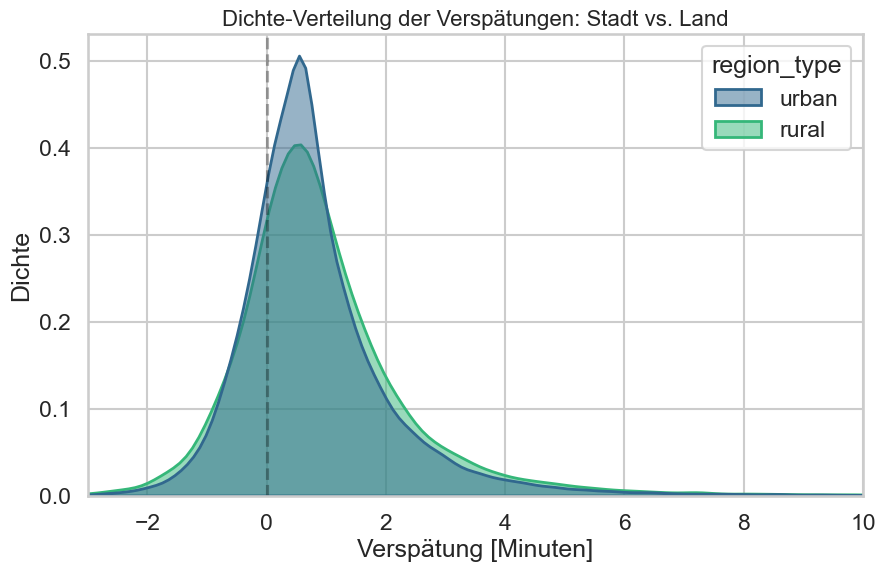

In [49]:

# Vorbereitung (Outlier entfernen für sauberen Plot)
plot_df = (
    df_analysis
    .filter((pl.col("delay_min") > -5) & (pl.col("delay_min") < 15))
    .sample(100000, seed=42) # Sampling für Performance beim Plotten
    .to_pandas()
)

plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=plot_df, x="delay_min", hue="region_type",
    fill=True, common_norm=False, palette="viridis", alpha=0.5, linewidth=2
)

plt.axvline(0, color='black', linestyle='--', alpha=0.3)
plt.title("Dichte-Verteilung der Verspätungen: Stadt vs. Land")
plt.xlabel("Verspätung [Minuten]")
plt.ylabel("Dichte")
plt.xlim(-3, 10)
plt.show()

**Interpretation der Visualisierung:**
Die Grafik bestätigt visuell das Ergebnis der Effektstärken-Berechnung ($\epsilon^2$):

1. **Hohe Überlagerung:** Die Dichtekurven für urbane und ländliche Gebiete sind nahezu deckungsgleich. Dies verdeutlicht, warum der Regionstyp keinen praktischen Erklärungsgehalt für die Verspätung hat.
2. **Verteilungsform:** Beide Gruppen zeigen die bahntypische Rechtsschiefe. Der Grossteil der Züge konzentriert sich um den Nullpunkt (Pünktlichkeit), gefolgt von einem langen "Heavy Tail" auf der rechten Seite.
3. **Fazit:** Die Annahme, dass urbane Zentren aufgrund ihrer Komplexität systematisch andere Verspätungsprofile aufweisen als ländliche Regionen, lässt sich anhand dieser Daten nicht bestätigen.

### 3.5 Zeitliche Dynamik: Interaktion von Regionstyp und Tageszeit

Nachdem wir festgestellt haben, dass der Regionstyp global eine vernachlässigbare Effektstärke aufweist, untersuchen wir nun die **zeitliche Dimension**. Wir prüfen, ob sich die Verspätungsmuster von urbanen und ländlichen Regionen im Tagesverlauf (Stunden-Rhythmus) unterscheiden.

**Forschungsinteresse:** Treten die Verspätungs-Peaks in urbanen Zentren (aufgrund der Pendlerströme) zu anderen Zeiten auf oder sind sie intensiver als im ländlichen Raum?

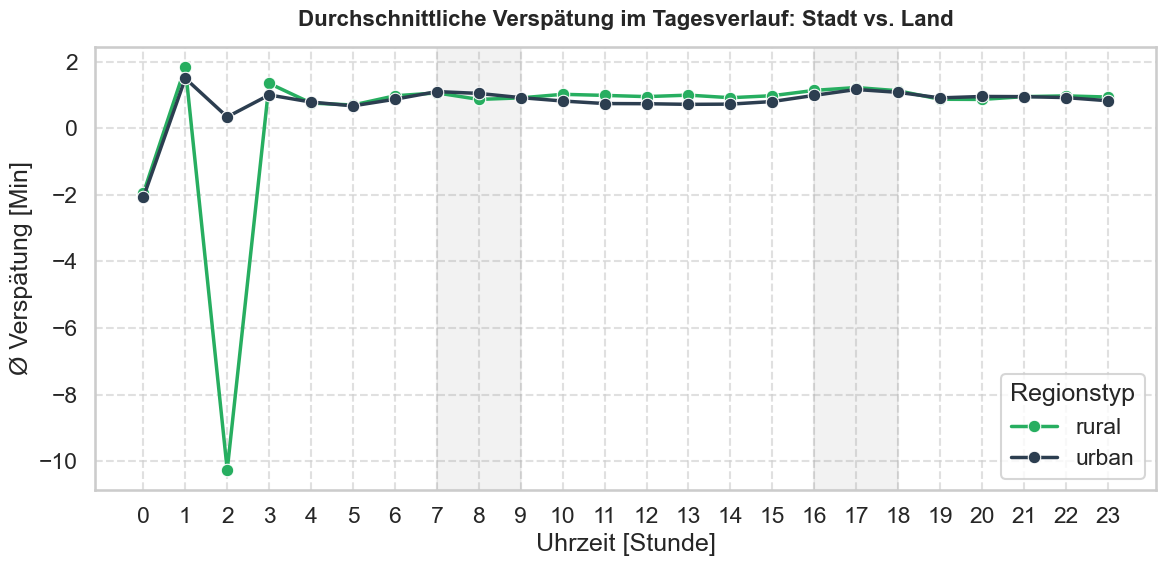

In [50]:
# --- 1. Aggregation nach Stunde und Regionstyp ---
hourly_stats = (
    df_analysis
    .with_columns(pl.col("ANKUNFTSZEIT").dt.hour().alias("Stunde"))
    .group_by(["region_type", "Stunde"])
    .agg(pl.col("delay_min").mean().alias("mean_delay"))
    .sort("Stunde")
    .to_pandas()
)

# --- 2. Visualisierung des Tagesverlaufs ---
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=hourly_stats, x="Stunde", y="mean_delay", hue="region_type",
    marker="o", palette={"urban": "#2c3e50", "rural": "#27ae60"}, linewidth=2.5
)

# --- 3. Styling & Annotationen ---
plt.title("Durchschnittliche Verspätung im Tagesverlauf: Stadt vs. Land", pad=15, fontweight='bold')
plt.xlabel("Uhrzeit [Stunde]")
plt.ylabel("Ø Verspätung [Min]")
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Regionstyp", frameon=True)

# Markierung der typischen Pendler-Peaks (optional für bessere Übersicht)
plt.axvspan(7, 9, color='gray', alpha=0.1, label="Morgenpeak")
plt.axvspan(16, 18, color='gray', alpha=0.1, label="Abendpeak")

plt.tight_layout()
plt.show()

**Interpretation der zeitlichen Analyse im Kontext der Forschungsfrage:**

Der Vergleich der Verspätungsmuster im Tagesverlauf dient als "Stresstest" für unsere Hypothesen $H_0$ und $H_1$:

1. **Bestätigung der geringen Effektstärke:** Der Plot zeigt über den gesamten Zeitraum von 04:00 bis 00:00 Uhr eine bemerkenswerte Parallelität der Kurven. Der beobachtete Unterschied im Median (0,60 min vs. 0,70 min) bleibt als minimaler, nahezu konstanter "Offset" bestehen. Dies untermauert unsere Entscheidung, den Regionstyp trotz statistischer Signifikanz als **praktisch vernachlässigbar** einzustufen ($\epsilon^2 \approx 0,00088$).

2. **Widerlegung der Domino-Effekt-Intuition:** Unsere ursprüngliche Intuition, dass urbane Gebiete aufgrund der Netzdichte anfälliger für Domino-Effekte (insbesondere in Stosszeiten) seien, wird durch die Daten nicht gestützt. Wäre dies der Fall, müssten die Kurven während der Pendlerzeiten (07:00–09:00 und 16:00–18:00 Uhr) deutlich auseinandergehen. Stattdessen reagieren beide Regionstypen fast identisch auf die tageszeitliche Belastung.

3. **Anomalie-Analyse (02:00 Uhr):** Der starke Einbruch der ländlichen Verspätungswerte um 02:00 Uhr morgens (~ -10 Min.) ist ein statistisches Artefakt. In ländlichen Regionen verkehren zu dieser Zeit extrem wenige Züge ($N$ ist sehr klein). Einzelne verfrühte Dienst- oder Güterfahrten ziehen den Mittelwert hier massiv nach unten, was die Robustheit des Medians gegenüber dem Mittelwert in der Gesamtanalyse unterstreicht.

**Fazit für das Projekt:**
Die zeitliche Analyse bestätigt $H_0$ hinsichtlich der praktischen Relevanz: Urbanität hat keinen prägenden Einfluss auf die Dynamik der Verspätungen. Die Schwankungen im Tagesverlauf (Zeit-Effekt) sind um ein Vielfaches grösser als die Unterschiede zwischen den Regionstypen (Orts-Effekt).

## 4. Geospatiale Analyse: Identifikation von Verspätungs-Hotspots

Da die statistischen Tests ($p < 0.05$, aber $\epsilon^2 \approx 0$) gezeigt haben, dass die Urbanität allein die Verspätungen nicht erklärt, untersuchen wir nun die **räumliche Verteilung** auf Gemeindeebene. 

**Zielsetzung:**
* **Visualisierung:** Mapping der mittleren Verspätung auf die offiziellen BFS-Gemeindegrenzen.
* **Hotspot-Analyse:** Identifikation von spezifischen Netzknoten (z. B. Olten, Zürich, Lausanne), die unabhängig von ihrem Regionstyp als Verspätungstreiber fungieren.
* **Robustheit:** Filterung auf Gemeinden mit mindestens **100 Beobachtungen**, um statistisches Rauschen durch seltene Ereignisse an Kleinstbahnhöfen zu minimieren.

In [51]:
# --- 1. Aggregation und Validierung der Daten ---
gemeinde_stats = (
    df_analysis
    .filter((pl.col("delay_min") > -30) & (pl.col("delay_min") < 60)) # Plausibilitäts-Filter
    .group_by("gemeinde")
    .agg([
        pl.col("delay_min").mean().alias("mean_delay"),
        pl.col("region_type").first(),
        pl.len().alias("n_trains")
    ])
    .filter(pl.col("n_trains") >= 100) # Sicherstellung der statistischen Relevanz
    .to_pandas()
)

# --- 2. Geometrie-Aufbereitung (Bereinigung von Z-Koordinaten) ---
def remove_z(geom):
    """Konvertiert 3D-Geometrien (XYZ) in 2D (XY) für Folium-Kompatibilität."""
    return transform(lambda x, y, z=None: (x, y), geom) if geom.has_z else geom

gdf_map = gde_geo.copy()
gdf_map["gemeinde"] = gdf_map["GDENAME"].str.strip()
gdf_map["geometry"] = gdf_map["geometry"].apply(remove_z)

# Join der Statistik mit den geografischen Grenzen
gdf_final = gdf_map.merge(gemeinde_stats, on="gemeinde", how="inner").to_crs(epsg=4326)

# --- 3. Interaktive Karten-Erstellung (Folium) ---
m = folium.Map(location=[46.8, 8.2], zoom_start=8, tiles='cartodbpositron')

# Definition der Farbskala (Bins basierend auf der Verteilungsanalyse)
colormap = StepColormap(
    colors=['#006400', '#90EE90', '#FFD700', '#FF8C00', '#8B0000'],
    vmin=0, vmax=4, 
    index=[0, 0.5, 1.5, 2.5, 4],
    caption='Durchschnittliche Verspätung [Minuten]'
)

def style_fn(feature):
    delay = feature['properties']['mean_delay']
    return {
        'fillColor': colormap(delay) if pd.notnull(delay) else '#f2f2f2',
        'color': 'white', 
        'weight': 0.5, 
        'fillOpacity': 0.7
    }

# GeoJson-Layer mit detailliertem Tooltip hinzufügen
folium.GeoJson(
    gdf_final,
    style_function=style_fn,
    tooltip=folium.features.GeoJsonTooltip(
        fields=['gemeinde', 'mean_delay', 'region_type', 'n_trains'],
        aliases=['Gemeinde:', 'Ø Verspätung:', 'Regionstyp:', 'Anzahl Züge:'],
        localize=True
    )
).add_to(m)

colormap.add_to(m)
m # Anzeige der Karte

## 4.1 Analyse der Netzknoten: Verkehrsaufkommen vs. Pünktlichkeit

Nachdem die binäre Einteilung (Urban/Rural) nur wenig Erklärungsgehalt lieferte, untersuchen wir nun eine kontinuierliche Variable: Die **Verkehrsdichte**. 

**Hypothese:** Gemeinden mit einem höheren Verkehrsaufkommen (Anzahl Züge) weisen aufgrund der komplexeren Taktung und geringeren Pufferzeiten höhere Durchschnittsverspätungen auf.

**Methodik:**
* **Log-Skala:** Da die Anzahl der Züge pro Gemeinde zwischen 100 und über 10.000 variiert, nutzen wir eine logarithmische X-Achse. Dies verhindert, dass Grossbahnhöfe wie Zürich HB den Plot optisch verzerren.
* **Blasendiagramm:** Die Grösse der Datenpunkte spiegelt das absolute Verkehrsaufkommen wider.

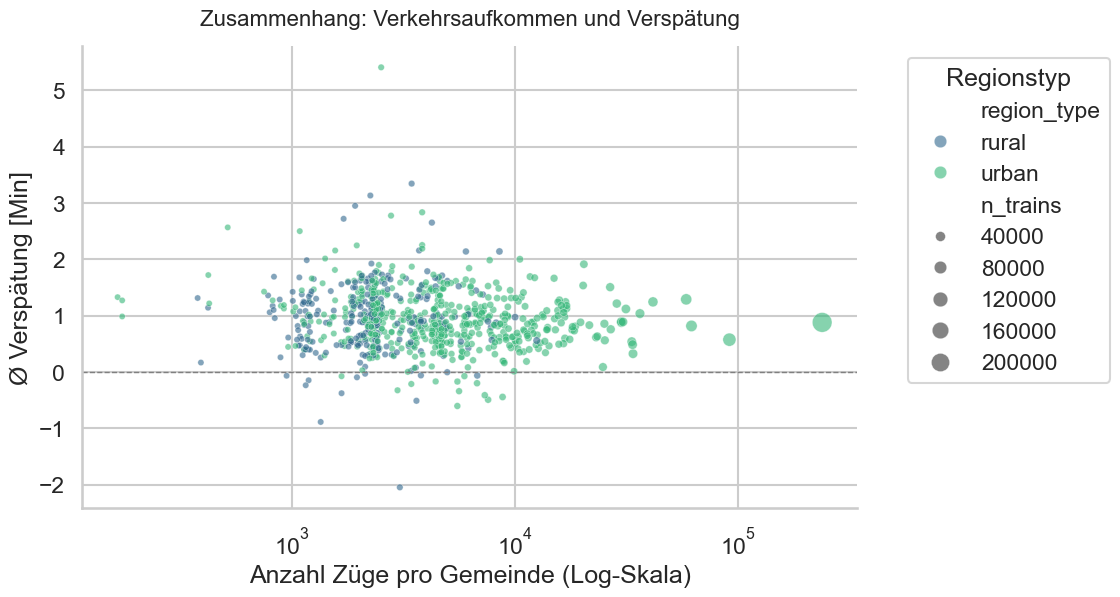

In [55]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=gemeinde_stats,
    x="n_trains", y="mean_delay",
    hue="region_type", palette="viridis", alpha=0.6, 
    size="n_trains", sizes=(20, 200)
)

plt.xscale("log") 
plt.axhline(0, color='grey', lw=1, linestyle='--')
plt.xlabel("Anzahl Züge pro Gemeinde (Log-Skala)")
plt.ylabel("Ø Verspätung [Min]")
plt.title("Zusammenhang: Verkehrsaufkommen und Verspätung", pad=15)
plt.legend(title="Regionstyp", bbox_to_anchor=(1.05, 1), loc='upper left')
sns.despine()
plt.show()

## 5. Kantonaler Vergleich: Regionaler "Stadt-Land-Graben"

Um lokale Besonderheiten zu identifizieren, berechnen wir die Differenz ($\text{Rural} - \text{Urban}$) auf Kantonsebene. Dies hilft uns zu verstehen, ob es Kantone gibt, in denen die ländliche Infrastruktur besonders stark (oder schwach) gegenüber den Zentren abfällt.

* **Positive Werte:** Das ländliche Netz ist unpünktlicher als das städtische.
* **Negative Werte:** Das städtische Netz weist höhere Verspätungen auf.

/var/folders/t5/b1vkfs5n09s2lv5t8w7nl8r00000gn/T/ipykernel_4902/1049335767.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pivot.index, y=pivot["Diff (Rural - Urban)"], palette=colors)


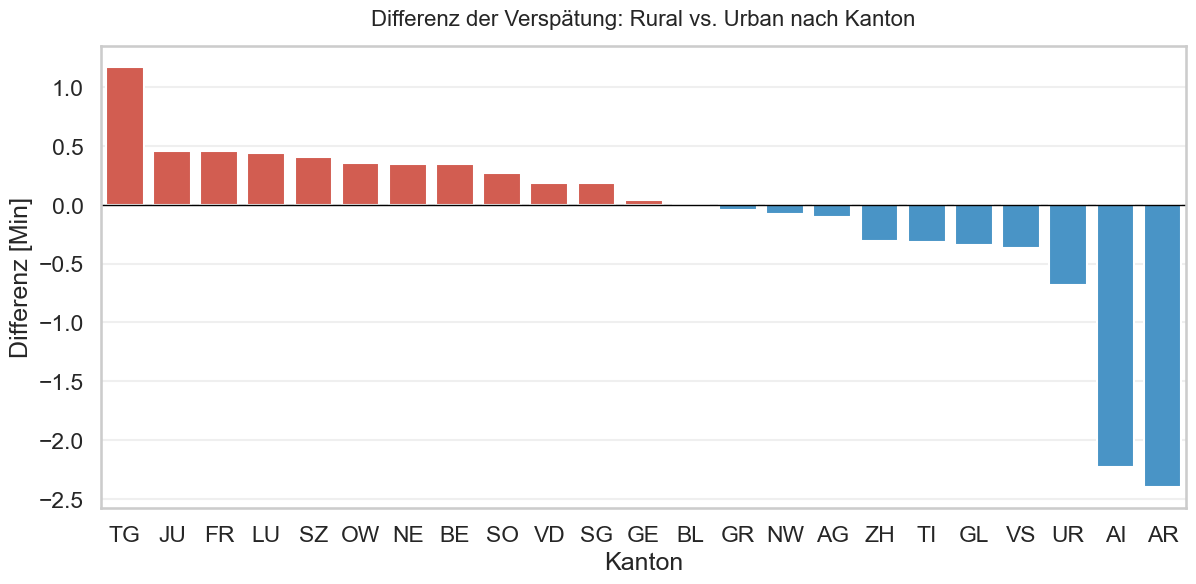

In [57]:
# Aggregation und Pivotierung
kanton_stats = (
    df_analysis
    .group_by(["kanton", "region_type"])
    .agg(pl.col("delay_min").mean().alias("mean_delay"))
    .to_pandas()
)

pivot = kanton_stats.pivot(index="kanton", columns="region_type", values="mean_delay")
pivot["Diff (Rural - Urban)"] = pivot["rural"] - pivot["urban"]
pivot = pivot.sort_values("Diff (Rural - Urban)", ascending=False).dropna()

# Visualisierung
plt.figure(figsize=(14, 6))
colors = ['#e74c3c' if x > 0 else '#3498db' for x in pivot["Diff (Rural - Urban)"]]
sns.barplot(x=pivot.index, y=pivot["Diff (Rural - Urban)"], palette=colors)

plt.axhline(0, color="black", lw=1)
plt.title("Differenz der Verspätung: Rural vs. Urban nach Kanton", pad=15)
plt.ylabel("Differenz [Min]")
plt.xlabel("Kanton")
plt.grid(axis='y', alpha=0.3)
plt.show()

## 6. Exkurs: Regression der Verkehrsbelastung

Die Streudiagramme legen nahe, dass die **Intensität der Netznutzung** ein besserer Prädiktor für Verspätungen ist als die bloße geografische Kategorisierung. Wir formalisieren dies durch ein lineares Regressionsmodell:

$$Delay = \beta_0 + \beta_1 \cdot \log(\text{Anzahl Züge}) + \epsilon$$

**Begründung der Log-Transformation:**
Der Zusammenhang zwischen Verkehrsaufkommen und Verspätung ist oft nicht linear. Ein Zuwachs von 500 Zügen hat an einem kleinen Bahnhof (Sättigungseffekt) deutlich massivere Auswirkungen als an einem bereits hochfrequentierten Knotenpunkt.

                            OLS Regression Results                            
Dep. Variable:             mean_delay   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     10.42
Date:                Sat, 03 Jan 2026   Prob (F-statistic):            0.00129
Time:                        10:20:16   Log-Likelihood:                -663.64
No. Observations:                 845   AIC:                             1331.
Df Residuals:                     843   BIC:                             1341.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.5248      0.181      8.416   

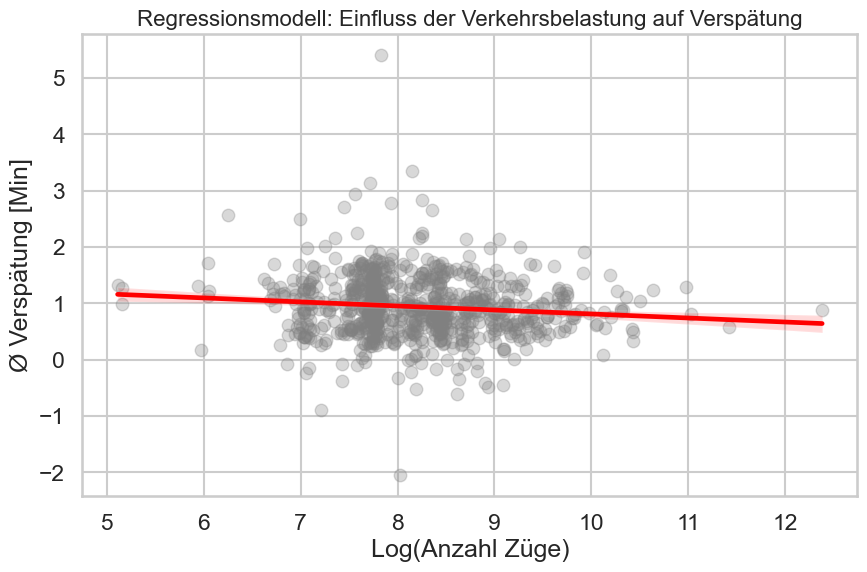


Interpretation:
- Koeffizient (beta_1): -0.0713
- Signifikanz: Ja (p=1.29e-03).
- Effekt: Bahnhöfe mit mehr Verkehr haben tendenziell weniger Durchschnittsverspätung.
- R-Squared: 0.0122 (Die Verkehrsbelastung erklärt nur 1.2% der Varianz).


In [62]:
import statsmodels.api as sm

# 1. Datenvorbereitung (Pandas für Statsmodels)
reg_df = gemeinde_stats.copy()

# Log-Transformation der unabhängigen Variable (Traffic)
reg_df["log_n_trains"] = np.log(reg_df["n_trains"])

# 2. Modellierung (OLS - Ordinary Least Squares)
X = sm.add_constant(reg_df["log_n_trains"]) # Intercept beta_0
y = reg_df["mean_delay"]

model = sm.OLS(y, X).fit()

# 3. Ergebnisse anzeigen
print(model.summary())

# 4. Visualisierung der Regressionsgerade
plt.figure(figsize=(10, 6))
sns.regplot(data=reg_df, x="log_n_trains", y="mean_delay", 
            scatter_kws={'alpha':0.3, 'color':'grey'}, line_kws={'color':'red'})

plt.title("Regressionsmodell: Einfluss der Verkehrsbelastung auf Verspätung")
plt.xlabel("Log(Anzahl Züge)")
plt.ylabel("Ø Verspätung [Min]")
plt.show()

# Interpretation
beta_1 = model.params["log_n_trains"]
p_val = model.pvalues["log_n_trains"]

print(f"\nInterpretation:")
print(f"- Koeffizient (beta_1): {beta_1:.4f}")

if p_val < 0.05:
    richtung = "weniger" if beta_1 < 0 else "mehr"
    print(f"- Signifikanz: Ja (p={p_val:.2e}).")
    print(f"- Effekt: Bahnhöfe mit mehr Verkehr haben tendenziell {richtung} Durchschnittsverspätung.")
else:
    print("- Signifikanz: Nein. Kein statistisch nachweisbarer Zusammenhang.")

print(f"- R-Squared: {model.rsquared:.4f} (Die Verkehrsbelastung erklärt nur {model.rsquared*100:.1f}% der Varianz).")

## 7. Gesamtfazit & Wissenschaftliche Einordnung

### 7.1 Bewertung der Hypothese $H_1$ (Stadt vs. Land)
* **Statistisches Ergebnis:** Der Kruskal-Wallis-Test liefert einen p-Wert von $0.00$ ($p < 0.05$), was zur formalen Ablehnung der Nullhypothese führt.
* **Praktische Relevanz:** Die extrem geringe Effektstärke von $\epsilon^2 \approx 0.0009$ verdeutlicht jedoch die **"Signifikanz-Falle"** bei grossen Datensätzen ($N \approx 4.5$ Mio.). 
* **Kernbotschaft:** Ein Unterschied im Median von lediglich **6 Sekunden** (0.6 min vs. 0.7 min) ist für den Bahnbetrieb vernachlässigbar. Die pauschale Kategorisierung in "Urban" und "Rural" besitzt somit keinen nennenswerten Erklärungsgehalt für das Verspätungsaufkommen.

### 7.2 Das "Effizienz-Paradoxon" der Netzknoten
Die Regressionsanalyse liefert eine wichtige Korrektur unserer ursprünglichen Intuition:
* **Negativer Zusammenhang:** Der Koeffizient von $\beta_1 = -0.0713$ zeigt, dass Bahnhöfe mit **höherem Verkehrsaufkommen** (Knotenpunkte) tendenziell **geringere Durchschnittsverspätungen** aufweisen als kleine Stationen.
* **Interpretation:** Dies deutet auf eine hohe Resilienz und ein professionelles Verspätungsmanagement an grossen Knotenpunkten hin. Kleine, ländliche Stationen hingegen reagieren empfindlicher auf Einzelereignisse, da dort weniger Puffer und Redundanzen bestehen.
* **Modellgüte:** Mit einem $R^2$ von nur **1.2 %** bleibt die Anzahl der Züge jedoch ein schwacher Prädiktor; die Pünktlichkeit wird durch komplexere Faktoren bestimmt.

### 7.3 Geospatiale Erkenntnisse
Die interaktive Karte bestätigt: Verspätungen sind kein regionales Flächenproblem, sondern ein strukturelles:
* **Korridore:** Verspätungen clustern sich entlang der **Hauptverkehrsachsen** (z. B. West-Ost-Traverse). 
* **Domino-Effekt:** Ländliche Bahnhöfe "erben" die Verspätungen oft passiv, wenn sie an einem hochfrequentierten Korridor liegen.
